# **5 - A/A Test**

Experimental Design and A/B testing

**Outline**

1. Topic Review
2. Simulating A/A test

# <font color='blue'>1. Topic Review</font>
---


**What is A/A Test?**

- A/A tests are the same as A/B tests, but Treatment and Control users receive **identical** experiences.
- If A/A test shows that each version works about the **same**, we can trust that **everything is set up right**.
- With an A/A test, we want to make sure that there is n**o difference between variants in the results**.

**Why A/A Tests?**
- To validate that we have set-up and run the test or experiment properly
- The generated data from experiment are accurate and reliable

**How to run A/A test?**

We can make simulation about A/A test result with the following steps :
1. First, randomly sampling data into two identical variants.
2. Then, calculate the means or proportions (depend on metric) of each variant
3. Run the statistical test and get the p-values
4. Repeat step 1-3 $n$ times and get $n$ p-values
5. Accumulate the $n$ p-values to histogram
6. Run the goodness-of-fit test for $n$ p-values data
  - We can use **Kolmogorov-Smirnov test** for goodness of fit test
  - The distribution of p-values under the Null hypothesis (equal means or proportions) should be **uniform**.


**Through this notebook, we will simulate the A/A test.**



# <font color='blue'>2. Simulating A/A Test</font>
---


## Simulating Good A/A test

- In this simulation, we will use dummy data.
- First, we create a dummy data set of historical data.
- The data is a 2-week A/A test experiment on channels that broadcast Mobile Legend with the metric **hours watched**.
- We would pull a data set for the past 2-week period containing channel_id and hours watched in that period for those channels that broadcast Mobile Legend.


In [1]:
# Import this library first
import numpy as np
import pandas as pd

In [2]:
# Generate data
np.random.seed(42)

# Generate 1000 data
n = 1000

# make dataframe
data = pd.DataFrame()

# make first column of dataframe that contain channel_id
# we want to generate data with the number of 1-1000 n times
data["channel_id"] = np.random.choice(1000, n,
                                      replace = False)

# make second column of dataframe that contain our metric
data['hours_watched'] = np.random.random(n)

# print 5 rows of data
data.head()

,channel_id,hours_watched
0,521,0.989960
1,737,0.322354
2,740,0.809874
3,660,0.254641
4,411,0.681503


In [3]:
# overview about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   channel_id     1000 non-null   int64  
 1   hours_watched  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


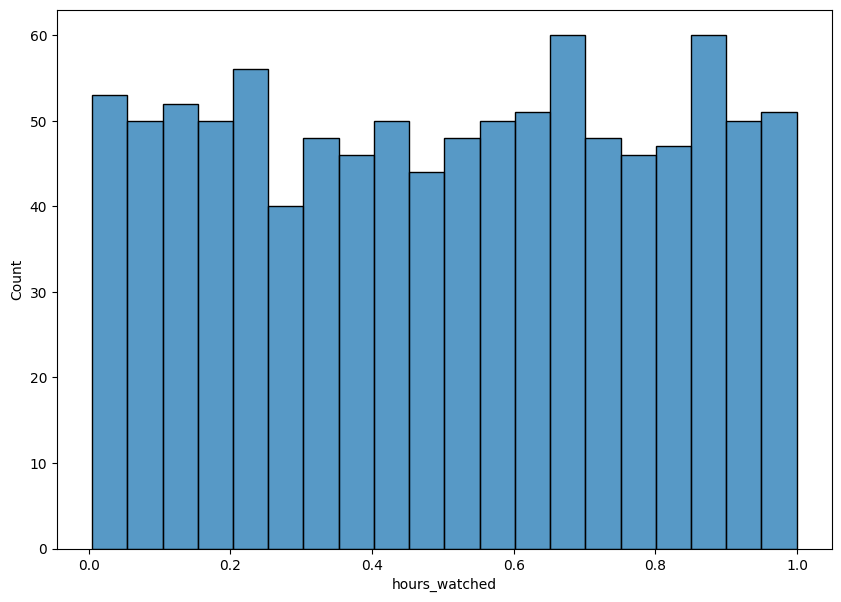

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

sns.histplot(data['hours_watched'],
             bins = 20,
             kde = False)

plt.show()

We can see that, the data generated have uniform distribution.

- Once the data set is created, the second step is to generate the $n$ distribution of p-values from simulated A/A tests.
- This is where we randomly divide the data into treatments or controls group for $n$ iterations
- Then, we calculate the average in each group for $n$ iterations
- After that, run the t-test on each split of $n$ iteration with the following hypothesis:

$$H_{0} : \mu_{\text{A}_{\text{control}}} = \mu_{\text{A}_{\text{treatment}}}$$
$$H_{1} : \mu_{\text{A}_{\text{control}}} \neq \mu_{\text{A}_{\text{treatment}}}$$



- To randomly sampling data into two group, it can be done with the syntax:

```python
data.sample(n = ...,
            replace =...)
```
- Descriptions

  - `n` : how many sample size. In this case we want to divide equally for two group, or 50:50.

  - `replace` : `True` for sampling with replacement or `False` for sampling without replacement

In [5]:
np.random.seed(1234)

# get control dataset
# Assign 50% of total data to control group
control_data = data.sample(frac = 0.5,
                           replace = False)

# get statistics for the control data
c_mean = control_data['hours_watched'].mean()   #mean
c_std  = control_data['hours_watched'].std()    #standar deviation
c_obs  = len(control_data)                      #number of observation

#print statistics of control data
print("A control")
print(f"mean                  : {c_mean:0.3f}")
print(f"standar deviation     : {c_std:0.3f}")
print(f"number of observation : {c_obs}")

A control
mean                  : 0.517
standar deviation     : 0.290
number of observation : 500


In [6]:
# get treatment dataset
# treatment dataset is the remaining data that has not been assigned to control

# Find the index of control data
index_control = control_data.index

# Find treatment data
# Treatment = Total - Control
treatment_data = data.drop(index = index_control)


# get statistics for the treatment data
t_mean = treatment_data['hours_watched'].mean()  #mean
t_std  = treatment_data['hours_watched'].std()   #standar deviation
t_obs = len(treatment_data)                      #number of observation

#print statistics of treatment data
print("A treatment")
print(f"mean                  : {t_mean:0.3f}")
print(f"standar deviation     : {t_std:0.3f}")
print(f"number of observation : {t_obs}")

A treatment
mean                  : 0.494
standar deviation     : 0.292
number of observation : 500


- Next, we will perform t-test for A control and A treatment\.

  - We will use another way for performing t-test, but use the same library as alwasy, namely `scipy`.
  - We will conduct T-test for means of two samples from descriptive statistics.
  - We can use function `stats.ttest_ind_from_stats`.


  - The syntax is
```python
scipy.stats.ttest_ind_from_stats(mean1, std1, nobs1,
                                     mean2, std2, nobs2,
                                     equal_var=...,
                                     alternative=...)
```

  - Description
    - `mean1` : The mean of group 1
    - `std1`  : standard deviation of group 1
    - `nobs1` : The number of observations of group 1
    - `mean2` :The mean of group 2
    - `std2`  : standard deviation of group 2
    - `nobs2` : The number of observations of group 2
    - equal_var : If `True` (default), perform a standard independent 2 sample test that assumes equal population variances. If `False`, perform t-test, which does not assume equal population variance
    - `alternative` : {`two-sided`, `less`, `greater`}, optional depend on hypothesis alternative. In this case, we use `two-sided`

In [7]:
# two sample t test
from scipy import stats

result = stats.ttest_ind_from_stats(mean1 = c_mean,  # control group
                                    std1 = c_std,
                                    nobs1 = c_obs,
                                    mean2 = t_mean,  # treatment group
                                    std2 = t_std,
                                    nobs2 = t_obs,
                                    equal_var = True, # Assume it is equal variance
                                    alternative = "two-sided")

# save p-value
pval = result[1]
print(f"p-value : {pval:0.3f}")

p-value : 0.216


- With one sampling attempt, the results obtained were p-value > 0.05 (not statistically significant).
- It means that, A control group is the same as A treatment group.
- However, if we **repeat the sampling experiment** many times and do the test, there will be 5% of p-value that have value less than 0.05.
- We will do simulation of $n$ times A/A test to prove that a good A/A test will have p-value distribution uniformly.

In [9]:
# define function for returns p-value
def AA_test(df, i):
    m1 = df['mean1'][i]
    m2 = df['mean2'][i]
    s1 = df['std1'][i]
    s2 = df['std2'][i]
    o1 = df['obs1'][i]
    o2 = df['obs2'][i]
    return(stats.ttest_ind_from_stats(mean1 = m1,
                                      std1 = s1,
                                      nobs1 = o1,
                                      mean2 = m2,
                                      std2 = s2,
                                      nobs2 = o2,
                                      equal_var = True,
                                      alternative = "two-sided")[1])

In [10]:
# returns dataframe with p-values
def p_values(dataset, metric, size, n_iter):
    """
    This function is used to simulate A/A test with n iteration

    args:
        - dataset (pandas Dataframe)    : sample dataset from online A/A test
        - metric (str)                  : name of column or metric that we want to simulate
        - size (float)                  : proportion of traffict for divide sample data to group control and treatment
        - n_iter (integer)              : number of iteration
    return:
        - df_results (pandas Dataframe) : output of the function that contain n p-values from t-test

    """
    # defining variables
    # Control group property list
    c_mean_list = []
    c_std_list = []
    c_obs_list = []

    # Treatment group property list
    t_mean_list = []
    t_std_list = []
    t_obs_list = []

    # loop for each n iteration
    for _ in range(n_iter):
        np.random.seed(_)

        # get control dataset
        control_data = dataset.sample(frac= size,
                                      replace = False)

        # get statistics of control data
        c_mean = control_data[metric].mean()
        c_std  = control_data[metric].std()
        c_obs  = len(control_data)

        # append statistics of control data
        c_mean_list.append(c_mean)
        c_std_list.append(c_std)
        c_obs_list.append(c_obs)

        # get treatment dataset
        # 1. Find the index of control data
        index_control = control_data.index

        # 2. Find treatment data
        # Treatment = Total - Control
        treatment_data = data.drop(index = index_control)

        # get statistics for treatment data
        t_mean = treatment_data[metric].mean()
        t_std  = treatment_data[metric].std()
        t_obs  = len(treatment_data)

        # append statistics of treatment data
        t_mean_list.append(t_mean)
        t_std_list.append(t_std)
        t_obs_list.append(t_obs)

    df_means = pd.DataFrame({'mean1':c_mean_list,
                             'mean2':t_mean_list,
                             'std1': c_std_list,
                             'std2': t_std_list,
                             'obs1': c_obs_list,
                             'obs2': t_obs_list})

    p_value_list = []

    # Calculate AA test p-value
    for i in range(n_iter):
        # Find the AA_test pvalue
        p_value_i = AA_test(df = df_means,
                            i = i)

        # Append AA_test pvalue
        p_value_list.append(p_value_i)

    # Convert p_value_list to dataframe
    df_results = pd.DataFrame(data = p_value_list,
                              columns = [f"{metric}_p_values"])


    return df_results


In [11]:
#simulate 200 times
df_results = p_values(dataset = data,
                      metric = 'hours_watched',
                      size = 0.5,
                      n_iter = 200)
df_results.head()

,hours_watched_p_values
0,0.274972
1,0.565491
2,0.257928
3,0.765842
4,0.459018


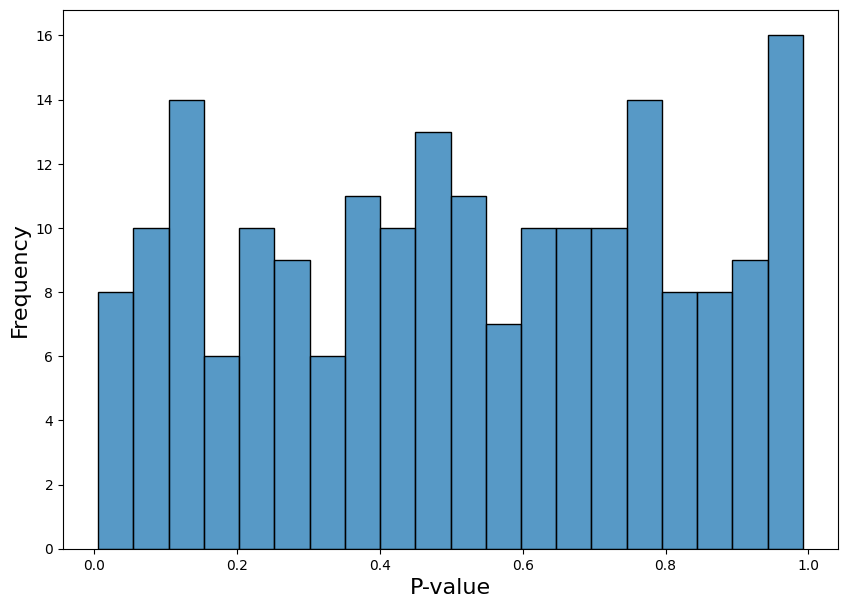

In [12]:
# Create a figure
fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=(10, 7))

# visualzation p-value in histogram
ax = sns.histplot(df_results['hours_watched_p_values'],
                  bins=20,
                  kde=False)

# add plot title and axis labels
ax.set_xlabel('P-value',
              fontsize = 16)
ax.set_ylabel('Frequency',
              fontsize = 16)

# display plot
plt.show()

From histogram of n p-values :
- Each of these t-tests on a randomly generated split generates a p-value, and we plot all the p-values in a histogram, which should exhibit a uniform distribution.

- In an A/A t-test that satisfies the underlying statistical assumptions for a t-test, the resulting p-value distribution should be uniform (so, a p-value < 0.05 should occur 5% of the time).

- Then, we run the goodness-of-fit test for n p-values data.
  - We can use **Kolmogorov-Smirnov test** for goodness of fit test
  - The distribution of p-values should be **uniform**.

- Hypothesis in the goodness of fit test for uniform distribution:

  $H_0$ : The data follow a uniform distribution

  $H_1$ : The data do not follow a uniform distribution

We can use function `result_ks` from `scipy` library, with the following syntax :  

```
stats.kstest(rvs = ..,
             cdf = ...)
```

Description :
- rvs : random variables or the data we want to test
- cdf : The name of distribution. It should be a string, and should be the name of a distribution in scipy.stats [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats)
In this case, we want to test uniform distribution. So, we can write `cdf = 'uniform'` in our syntax

In [13]:
# Perform kolmogorov smirnof (KS) test
result_ks = stats.kstest(rvs = df_results['hours_watched_p_values'],
                         cdf = 'uniform')

# save p-value of KS test
p_value = result_ks[1]

#print p-value
print(p_value)

0.8284088612555435


In [14]:
# Make decision from kolmogorof smirnov test
# We can compare p-value with alpha
# if p-value > alpha, then fail to reject H0. It means that the data is uniformly distributed

alpha = 0.05
if(p_value <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Fail to Reject Null Hypothesis


**Conclusion**

- The result of KS test is fail to reject H0. It means that the data is **uniformly distributed**

- From simulation the A/A test, it can be conclude there is no problem with our design experimentation.

## Simulating Problematic A/A test with outlier

- Same as before, in this simulation, we will use dummy data. But, the metric contains **outliers**
- First, we create a dummy data set of historical data.
- The data is a 2-week A/A test experiment on channels that broadcast Mobile Legend with the metric **hours watched with outlier**.
- We would pull a data set for the past 2-week period containing channel_id and hours watched in that period for those channels that broadcast Mobile Legend.

In [15]:
# Generate data
np.random.seed(42)

# Generate 1000 data
n = 1000

#make dataframe
data = pd.DataFrame()

#make first column of dataframe that contain channel_id
data["channel_id"] = np.random.choice(1000, n, replace = False)

#make second column of dataframe that contain our metric
data['hours_watched_outlier'] = np.random.random(1000)

#add outlier in the first row
data['hours_watched_outlier'].iloc[0] = 1000

#print 5 row data
data.head()

<ipython-input-15-4727ac1eb891>:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['hours_watched_outlier'].iloc[0] = 1000
<ipython-input-15-4727ac1eb891>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,channel_id,hours_watched_outlier
0,521,1000.000000
1,737,0.322354
2,740,0.809874
3,660,0.254641
4,411,0.681503


In [16]:
# overview about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   channel_id             1000 non-null   int64  
 1   hours_watched_outlier  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


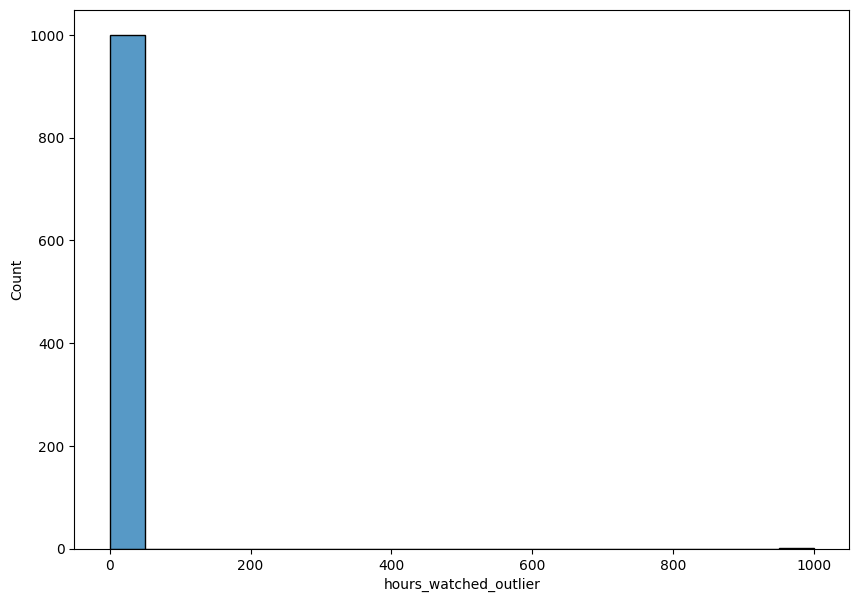

In [17]:
fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=(10, 7))

sns.histplot( data['hours_watched_outlier'], bins=20, kde=False)

plt.show()

- Once the data set is created, the second step is to generate the $n$ distribution of p-values from simulated A/A tests.
- This is where we randomly divide the data into treatments or controls group for $n$ iterations
- Then, we calculate the average in each group for $n$ iterations
- After that, run the t-test on each split of $n$ iteration with the following hypothesis:

$$H_{0} : \mu_{\text{A}_{\text{control}}} = \mu_{\text{A}_{\text{treatment}}}$$
$$H_{1} : \mu_{\text{A}_{\text{control}}} \neq \mu_{\text{A}_{\text{treatment}}}$$



- To randomly sampling data into two group, it can be done with the syntax:

```python
data.sample(n = ...,
            replace =...)
```
- Descriptions

  - `n` : how many sample size. In this case we want to divide equally for two group, or 50:50.

  - `replace` : `True` for sampling with replacement or `False` for sampling without replacement

In [18]:
np.random.seed(1234)

# get control dataset
# Assign 50% of total data to control group
control_data = data.sample(frac= 0.5,
                           replace = False)

# get statistics for the control data
c_mean = control_data['hours_watched_outlier'].mean()   #mean
c_std  = control_data['hours_watched_outlier'].std()    #standar deviation
c_obs  = len(control_data)                      #number of observation

#print statistics of control data
print("A control")
print(f"mean                  : {c_mean:0.3f}")
print(f"standar deviation     : {c_std:0.3f}")
print(f"number of observation : {c_obs}")

A control
mean                  : 0.517
standar deviation     : 0.290
number of observation : 500


In [19]:
# get treatment dataset
# treatment dataset is the remaining data that has not been assigned to control
# 1. Find the index of control data
index_control = control_data.index

# 2. Find treatment data
# Treatment = Total - Control
treatment_data = data.drop(index = index_control)

# get statistics for the treatment data
t_mean = treatment_data['hours_watched_outlier'].mean()  #mean
t_std  = treatment_data['hours_watched_outlier'].std()   #standar deviation
t_obs  = len(treatment_data)                             #number of observation

#print statistics of treatment data
print("A treatment")
print(f"mean                  : {t_mean:0.3f}")
print(f"standar deviation     : {t_std:0.3f}")
print(f"number of observation : {t_obs}")

A treatment
mean                  : 2.492
standar deviation     : 44.700
number of observation : 500


In [20]:
# two sample t test
from scipy import stats

result = stats.ttest_ind_from_stats(mean1 = c_mean,  # control group
                                    std1 = c_std,
                                    nobs1 = c_obs,
                                    mean2 = t_mean,  # treatment group
                                    std2 = t_std,
                                    nobs2 = t_obs,
                                    equal_var = True, # Assume equal variance
                                    alternative = "two-sided")

# save p-value
pval = result[1]
print(f"p-value : {pval:0.3f}")

p-value : 0.323


In [21]:
#simulate 200 times
df_results = p_values(dataset = data,
                      metric = 'hours_watched_outlier',
                      size = 0.5,
                      n_iter = 200)
df_results.head()

,hours_watched_outlier_p_values
0,0.312958
1,0.315248
2,0.322886
3,0.316480
4,0.321126


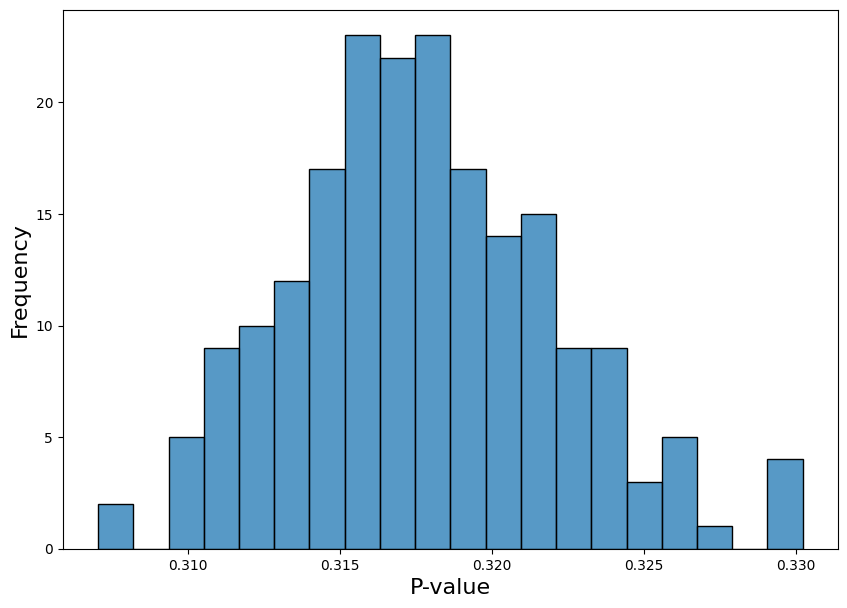

In [22]:
# Create a figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# visualzation p-value in histogram
ax = sns.histplot(df_results['hours_watched_outlier_p_values'], bins=20, kde=False)

# add plot title and axis labels
ax.set_xlabel('P-value', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)

# display plot
plt.show()

- We can see from histogram, that the histogram of n p-values from A/A test that contain outlier is **far from uniform distribution**.

- The p-value distributions are obviously not uniform, but you still need to statistically confirm whether a distribution is uniform or not.


- Then, we run the goodness-of-fit test for n p-values data.
  - We can use **Kolmogorov-Smirnov test** for goodness of fit test
  - The distribution of p-values should be **uniform**.

- Hypothesis in the goodness of fit test for uniform distribution:

  $H_0$ : The data follow a uniform distribution

  $H_1$ : The data do not follow a uniform distribution

- Like the previous section, we can use function `result_ks` from `scipy` library

In [23]:
# Perform kolmogorov smirnof (KS) test
result_ks = stats.kstest(rvs = df_results['hours_watched_outlier_p_values'],
                         cdf = "uniform")

# save p-value of KS test
p_value = result_ks[1]

#print p-value
print(p_value)

5.01660079210128e-89


In [24]:
# Make decision from kolmogorof smirnov test
# We can compare p-value with alpha
# if p-value > alpha, then fail to reject H0. It means that the data is uniformly distributed

alpha = 0.05
if(p_value <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Reject Null Hypothesis


**Conclusion**

- The result of KS test is reject $H_0$. It means that the data is **not uniformly distributed**

- From simulation of problematic the A/A test, it can be conclude that if there is outlier in our data,, the distribution of n pvalues is not uniform distribution.

- We cann't detect the present of outlier in one t-test, we should doing simulation $n$ times simulation of A/A test.

## Simulating A/A test with skew distribution of sample data

- In the previous section, we generate data sample that have uniform distribution.
- In this section, we will generate metric hours watched from gamma distribution with the high skewness.


In [25]:
# Import this library first
import numpy as np
import pandas as pd

In [26]:
# Generate data
np.random.seed(42)

# Generate 1000 data
n = 1000

#make dataframe
data = pd.DataFrame()

#make first column of dataframe that contain channel_id
data["channel_id"] = np.random.choice(1000, n, replace = False)  # we want to generate data with the number of 1-1000 n times

#make second column of dataframe that contain our metric
data['hours_watched_skew'] = np.random.gamma(shape = 0.5,scale = 1, size = n)

#print 5 rows of data
data.head()

,channel_id,hours_watched_skew
0,521,0.967197
1,737,0.526346
2,740,0.367417
3,660,0.169613
4,411,2.189525


In [27]:
# overview about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channel_id          1000 non-null   int64  
 1   hours_watched_skew  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


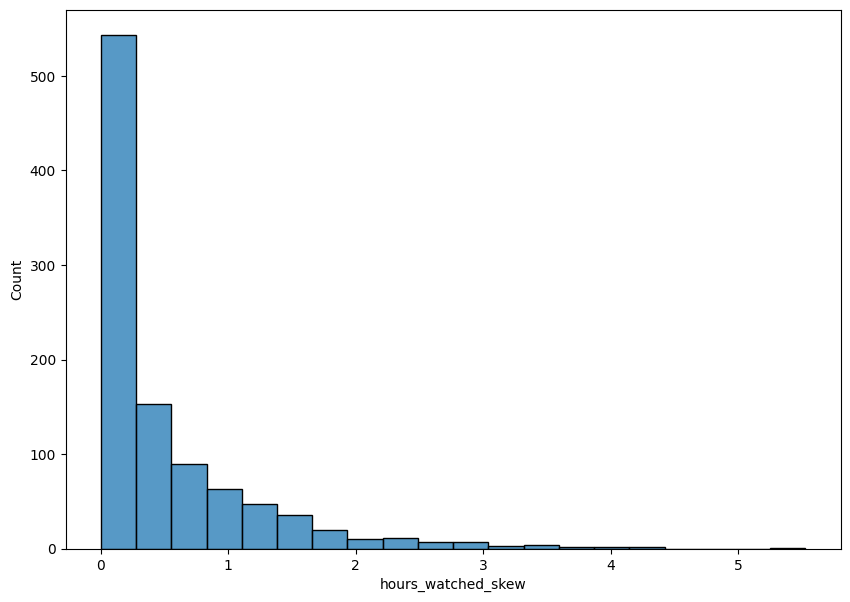

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

sns.histplot(data['hours_watched_skew'],
             bins = 20,
             kde = False)

plt.show()

We can see that, the data generated have skew distribution.

- Once the data set is created, the second step is to generate the $n$ distribution of p-values from simulated A/A tests.
- This is where we randomly divide the data into treatments or controls group for $n$ iterations
- Then, we calculate the average in each group for $n$ iterations
- After that, run the t-test on each split of $n$ iteration with the following hypothesis:

$$H_{0} : \mu_{\text{A}_{\text{control}}} = \mu_{\text{A}_{\text{treatment}}}$$
$$H_{1} : \mu_{\text{A}_{\text{control}}} \neq \mu_{\text{A}_{\text{treatment}}}$$



- To randomly sampling data into two group, it can be done with the syntax:

```python
data.sample(n = ...,
            replace =...)
```
- Descriptions

  - `n` : how many sample size. In this case we want to divide equally for two group, or 50:50.

  - `replace` : `True` for sampling with replacement or `False` for sampling without replacement

In [29]:
np.random.seed(1234)

# get control dataset
# Assign 50% of total data to control group
control_data = data.sample(frac= 0.5,
                           replace = False)

# get statistics for the control data
c_mean = control_data['hours_watched_skew'].mean()   #mean
c_std  = control_data['hours_watched_skew'].std()    #standar deviation
c_obs  = len(control_data)                      #number of observation

#print statistics of control data
print("A control")
print(f"mean                  : {c_mean:0.3f}")
print(f"standar deviation     : {c_std:0.3f}")
print(f"number of observation : {c_obs}")

A control
mean                  : 0.553
standar deviation     : 0.728
number of observation : 500


In [30]:
# get treatment dataset
# treatment dataset is the remaining data that has not been assigned to control

# 1. Find the index of control data
index_control = control_data.index

# 2. Find treatment data
# Treatment = Total - Control
treatment_data = data.drop(index = index_control)


# get statistics for the treatment data
t_mean = treatment_data['hours_watched_skew'].mean()  #mean
t_std  = treatment_data['hours_watched_skew'].std()   #standar deviation
t_obs = len(treatment_data)                      #number of observation

#print statistics of treatment data
print("A treatment")
print(f"mean                  : {t_mean:0.3f}")
print(f"standar deviation     : {t_std:0.3f}")
print(f"number of observation : {t_obs}")

A treatment
mean                  : 0.480
standar deviation     : 0.686
number of observation : 500


Findings :

- From the statistics descriptive, we can see that although the distribution have the high skewness data. There is not significant different.
- But, we should perform hypothesis testing to prove the different between two group

In [31]:
# two sample t test
from scipy import stats

result = stats.ttest_ind_from_stats(mean1 = c_mean,  # control group
                                    std1 = c_std,
                                    nobs1 = c_obs,
                                    mean2 = t_mean,  # treatment group
                                    std2 = t_std,
                                    nobs2 = t_obs,
                                    equal_var = True, # Assume it is equal variance
                                    alternative = "two-sided")

# save p-value
pval = result[1]
print(f"p-value : {pval:0.3f}")

p-value : 0.105


- With one sampling attempt, the results obtained were p-value > 0.05 (not statistically significant).
- It means that, there is no different between treatment and control group.

- We will simulate the A/A test with the skew metric.
- We can directly run the function that we have defined in the first section

In [32]:
#simulate 200 times
df_results = p_values(dataset = data,
                      metric = 'hours_watched_skew',
                      size = 0.5,
                      n_iter = 200)

#print result
df_results.head()

,hours_watched_skew_p_values
0,0.075896
1,0.478323
2,0.129242
3,0.682737
4,0.397932


- After that, we make histogram of p-value to see the plot of distribution

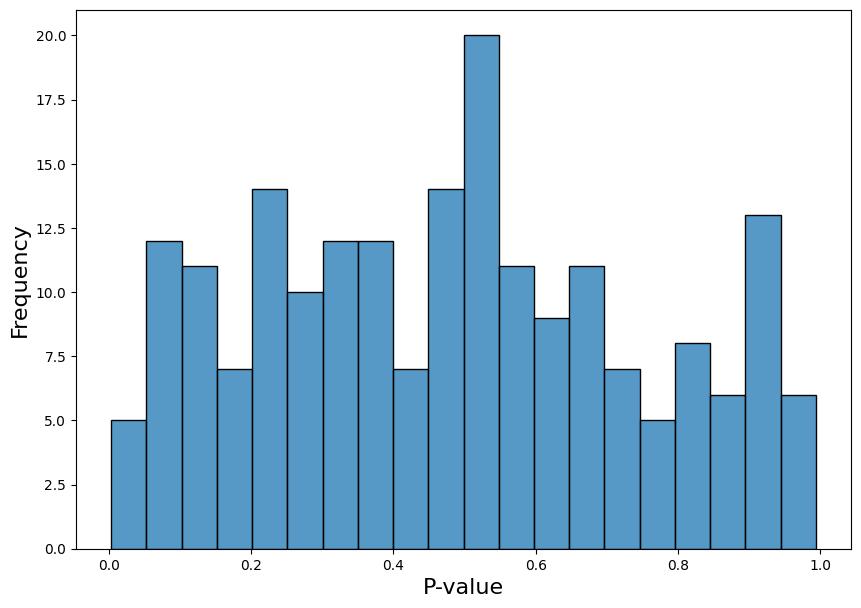

In [33]:
# Create a figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# visualzation p-value in histogram
ax = sns.histplot(df_results['hours_watched_skew_p_values'], bins=20, kde=False)

# add plot title and axis labels
ax.set_xlabel('P-value', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)

# display plot
plt.show()

From histogram of 200 p-values :
- It should be 5% of 200 iterations (or 10 test) that has the p-value < 0.05, but from the histogram, there are more than 5% of times that the p-value < 0.05.

- This indicates there is a problem with our experiment. Obviously, because our metrics or data have high skew.

- With the A/A test simulation, we can detect that there is a problem



- Then, we run the goodness-of-fit test for n p-values data.
  - We can use **Kolmogorov-Smirnov test** for goodness of fit test
  - The distribution of p-values should be **uniform**.

- Hypothesis in the goodness of fit test for uniform distribution:

  $H_0$ : The data follow a uniform distribution

  $H_1$ : The data do not follow a uniform distribution

We can use function `result_ks` from `scipy` library, with the following syntax :  

```
stats.kstest(rvs= ..,
             cdf= ...)
```

Description :
- rvs : random variables or the data we want to test
- cdf : The name of distribution. It should be a string, and should be the name of a distribution in scipy.stats [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats)

In [34]:
# Perform kolmogorov smirnof (KS) test
result_ks = stats.kstest(rvs = df_results['hours_watched_skew_p_values'],
                         cdf = "uniform")

# save p-value of KS test
p_value = result_ks[1]

#print p-value
print(p_value)

0.031203762164840776


In [35]:
# Make decision from kolmogorof smirnov test
# We can compare p-value with alpha
# if p-value > alpha, then fail to reject H0. It means that the data is uniformly distributed

alpha = 0.05
if(p_value <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Reject Null Hypothesis


**Conclusion**

- The result of KS test is reject $H_0$. It means that the data is **not uniformly distributed** for metric that have high skew data.

---
**Question!**

What if the metric data has a pattern that is close to a normal distribution, will the distribution of the p-values be uniform or not if the A/A test is simulated?

Reference of this notebook


[Reference 1](https://github.com/LeihuaYe/Statistical_Simulation_In_Python/blob/master/4.%20AA%20Test.ipynb)

[Reference 2](https://blog.twitch.tv/en/2021/11/04/simulated-bootstrapped-aa-tests-1/)